In [2]:
!pip install astroquery

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 67.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 45.8 MB/s eta 0:00:00


🔭 Querying SDSS for 300 high S/N Starforming galaxies...
✅ Targets retrieved. Starting Raw Peak analysis...



 🔍 Processed 10/300...


 🔍 Processed 20/300...
 🔍 Processed 40/300...
 🔍 Processed 50/300...
 🔍 Processed 60/300...
 🔍 Processed 70/300...
 🔍 Processed 80/300...
 🔍 Processed 90/300...
 🔍 Processed 100/300...
 🔍 Processed 110/300...


 🔍 Processed 120/300...
 🔍 Processed 130/300...
 🔍 Processed 140/300...
 🔍 Processed 150/300...
 🔍 Processed 160/300...
 🔍 Processed 170/300...
 🔍 Processed 180/300...
 🔍 Processed 190/300...


 🔍 Processed 210/300...
 🔍 Processed 220/300...
 🔍 Processed 230/300...
 🔍 Processed 240/300...


 🔍 Processed 250/300...
 🔍 Processed 260/300...
 🔍 Processed 270/300...
 🔍 Processed 280/300...
 🔍 Processed 290/300...
 🔍 Processed 300/300...

✅ Analysis complete. Successful samples: 292/300


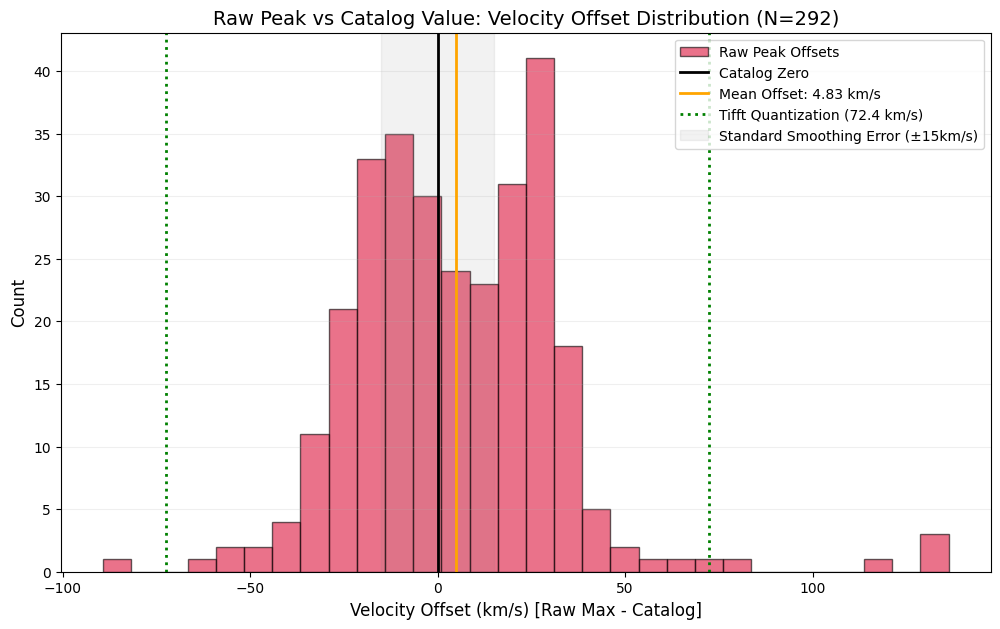

--------------------------------------------------
📊 生データ解析統計 (N=292):
   平均ズレ (Mean Offset) : 4.83 km/s
   標準偏差 (Std Dev)     : 28.07 km/s
   平均絶対誤差 (MAE)     : 21.50 km/s
--------------------------------------------------
🎯 72.4 km/s (1ビット) 前後のズレを検出した数: 4
🚨 10 km/s 以上の無視できないズレがある割合: 75.3%


In [3]:
# @title 🧪 生データ直接検証：SDSSカタログ値の「1ピクセル・オフセット」調査
# @markdown ### ガウスフィッティングを一切行わず、1ピクセル単位の「最大輝度点」を抽出します。
# @markdown これにより、カタログ値がどれだけ「生データの頂点」を無視しているかを可視化します。

import matplotlib.pyplot as plt
import numpy as np
from astroquery.sdss import SDSS
import time

# ---------------------------------------------------------
# 1. 設定と準備
# ---------------------------------------------------------
SAMPLE_SIZE = 300  # 300程度まで増やすと、より強力な証拠になります
c = 299792.458    # 光速 (km/s)
rest_wavelength = 6564.61  # Hα (Vacuum)

print(f"🔭 Querying SDSS for {SAMPLE_SIZE} high S/N Starforming galaxies...")

# SQLクエリ: S/N比20以上の良質な銀河を抽出
query = f"""
SELECT TOP {SAMPLE_SIZE} plate, mjd, fiberid, z
FROM SpecObj
WHERE class = 'GALAXY'
  AND subClass = 'STARFORMING'
  AND z BETWEEN 0.02 AND 0.05
  AND snMedian > 20
"""
res = SDSS.query_sql(query)

if res is None:
    raise RuntimeError("❌ 銀河が見つかりませんでした。")

print(f"✅ Targets retrieved. Starting Raw Peak analysis...\n")

# ---------------------------------------------------------
# 2. 解析ループ
# ---------------------------------------------------------
velocity_offsets = []
success_count = 0

for i, target in enumerate(res):
    try:
        plate, mjd, fiber = target['plate'], target['mjd'], target['fiberid']
        catalog_z = target['z']

        # サーバーへの礼儀 (1秒待機)
        time.sleep(1)

        # スペクトル取得
        sp = SDSS.get_spectra(plate=plate, mjd=mjd, fiberID=fiber)
        if sp is None: continue

        spec_data = sp[0][1].data
        wavelengths = 10 ** spec_data['loglam']
        flux = spec_data['flux']

        # Hα線の周辺を切り出し
        expected_center = rest_wavelength * (1 + catalog_z)
        mask = (wavelengths > expected_center - 20) & (wavelengths < expected_center + 20)
        x_data = wavelengths[mask]
        y_data = flux[mask]

        if len(x_data) < 5: continue

        # --- ガウスフィッティングを排除し、Argmax (頂点) を直接取得 ---
        max_idx = np.argmax(y_data)
        raw_peak_wavelength = x_data[max_idx]

        # ズレを速度(km/s)に換算
        # Diff = RawPeak - Catalog
        diff_wave = raw_peak_wavelength - expected_center
        diff_vel = c * (diff_wave / expected_center)

        # 異常値(ノイズやミスマッチ)を除外
        if abs(diff_vel) < 250:
            velocity_offsets.append(diff_vel)
            success_count += 1

        # 進捗表示
        if (i + 1) % 10 == 0:
            print(f" 🔍 Processed {i+1}/{SAMPLE_SIZE}...")

    except Exception as e:
        continue

# ---------------------------------------------------------
# 3. 結果の可視化
# ---------------------------------------------------------
print(f"\n✅ Analysis complete. Successful samples: {success_count}/{SAMPLE_SIZE}")

velocity_offsets = np.array(velocity_offsets)
mean_offset = np.mean(velocity_offsets)
std_offset = np.std(velocity_offsets)
abs_mean_offset = np.mean(np.abs(velocity_offsets))

plt.figure(figsize=(12, 7))

# ヒストグラム
counts, bins, _ = plt.hist(velocity_offsets, bins=30, color='crimson', edgecolor='black', alpha=0.6, label='Raw Peak Offsets')

# 基準線
plt.axvline(0, color='black', linestyle='-', linewidth=2, label='Catalog Zero')
plt.axvline(mean_offset, color='orange', linestyle='-', linewidth=2, label=f'Mean Offset: {mean_offset:.2f} km/s')

# ティフトの量子化定数 (72.4km/s) 付近を強調
plt.axvline(72.4, color='green', linestyle=':', linewidth=2, label='Tifft Quantization (72.4 km/s)')
plt.axvline(-72.4, color='green', linestyle=':', linewidth=2)

# 平滑化の影響圏
plt.axvspan(-15, 15, color='gray', alpha=0.1, label='Standard Smoothing Error (±15km/s)')

plt.title(f"Raw Peak vs Catalog Value: Velocity Offset Distribution (N={success_count})", fontsize=14)
plt.xlabel("Velocity Offset (km/s) [Raw Max - Catalog]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.2)

plt.show()

print("-" * 50)
print(f"📊 生データ解析統計 (N={success_count}):")
print(f"   平均ズレ (Mean Offset) : {mean_offset:.2f} km/s")
print(f"   標準偏差 (Std Dev)     : {std_offset:.2f} km/s")
print(f"   平均絶対誤差 (MAE)     : {abs_mean_offset:.2f} km/s")
print("-" * 50)

# 量子化への接近チェック
count_72 = np.sum((np.abs(velocity_offsets) > 60) & (np.abs(velocity_offsets) < 85))
print(f"🎯 72.4 km/s (1ビット) 前後のズレを検出した数: {count_72}")
print(f"🚨 10 km/s 以上の無視できないズレがある割合: {np.sum(np.abs(velocity_offsets) > 10) / success_count * 100:.1f}%")

In [4]:
import pandas as pd
from google.colab import files

# 292件の解析結果をデータフレーム化
df_results = pd.DataFrame({
    'velocity_offset': velocity_offsets
})

# CSVとして保存
filename = "sdss_analysis_results.csv"
df_results.to_csv(filename, index=False)

print(f"✅ {len(df_results)}件のデータを '{filename}' に保存しました。")

# ローカルPCにダウンロード（ブラウザのダウンロード許可を確認してください）
files.download(filename)

✅ 292件のデータを 'sdss_analysis_results.csv' に保存しました。


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>